In [3]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
from time import sleep 
import scrapy
import random
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import time
from pandas import ExcelWriter
import xlsxwriter
import openpyxl
from openpyxl import workbook

In [4]:
# Instalamos en CONDA " pyLDAvis.gensim install conda " y " pyldavis install conda "

import pandas as pd
import os 
import re
from wordcloud import WordCloud

# Leemos los datos
papers = pd.read_excel('DatosInvestigacion1-CargaCompleta.xlsx')
# Imprimimos los datos
papers.head()

,ID,TITULO,MES,AÑO,AUTORES,REVISTA,CITACIONES,REFERENCIAS
0,1,Security modelling and assessment of modern ne...,Dec15,2019,"Enoch, SY; Hong, JB and Kim, DS",JOURNAL OF NETWORK AND COMPUTER APPLICATIONS,5,52
1,2,Formalization of security patterns as a means ...,Feb,2015,"Varela-Vaca, AJ and Gasca, RM",LOGIC JOURNAL OF THE IGPL,5,32
2,3,Catalytic Decomposition of N2O over Co-Ti Oxid...,Jun21,2016,"Zhang, C; Zhang, ZP; (...); Zhu, YJ",CHEMCATCHEM,26,56
3,4,Security of electronic personal health informa...,Mar4,2022,"Chuma, KG and Ngoepe, M",INFORMATION SECURITY JOURNAL,1,59
4,5,Reversible Fluorescence Switching of Metal-Org...,Apr24,2020,"Venkateswarlu, S; Reddy, AS; (...); Yoon, MY",ACS APPLIED NANO MATERIALS,23,41


In [5]:
# Eliminamos las columnas
papers = papers.drop(columns=['ID', 'MES', 'AÑO', 'AUTORES', 'CITACIONES', 'REFERENCIAS'], axis=1).sample(100)
# Imprimimos
papers.head()

,TITULO,REVISTA
196,Teff consumption and anemia in pregnant Ethiop...,EUROPEAN JOURNAL OF NUTRITION
245,Anthropo-entomophagy: quantitatively chemical ...,ENVIRONMENTAL SCIENCE AND POLLUTION RESEARCH
305,Ultrafast Chemical Reactions in Shocked Nitrom...,JOURNAL OF PHYSICAL CHEMISTRY A
527,On-line UV photochemical generation of volatil...,MICROCHEMICAL JOURNAL
588,Assessing the reactivity of TiCl3 and TiF3 wit...,INTERNATIONAL JOURNAL OF HYDROGEN ENERGY


In [6]:
# Quitar 
papers['TITULO_processed'] = \
papers['TITULO'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convertir los títulos a minúsculas 
papers['TITULO_processed'] = \
papers['TITULO'].map(lambda x: x.lower())
# Imprime las primeras filas de papeles 
papers['TITULO_processed'].head()



196    teff consumption and anemia in pregnant ethiop...
245    anthropo-entomophagy: quantitatively chemical ...
305    ultrafast chemical reactions in shocked nitrom...
527    on-line uv photochemical generation of volatil...
588    assessing the reactivity of ticl3 and tif3 wit...
Name: TITULO_processed, dtype: object

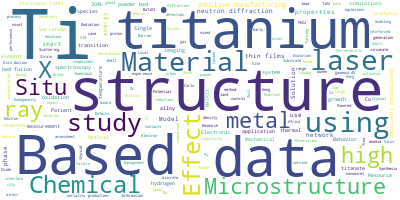

In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['TITULO'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'Security', 'TI'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.TITULO.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words)

[['teff', 'consumption', 'anemia', 'pregnant', 'ethiopian', 'women', 'case', 'control', 'study'], ['anthropo', 'entomophagy', 'quantitatively', 'chemical', 'assessment', 'edible', 'arthropods', 'bought', 'shop'], ['ultrafast', 'chemical', 'reactions', 'shocked', 'nitromethane', 'probed', 'dynamic', 'ellipsometry', 'transient', 'absorption', 'spectroscopy'], ['line', 'uv', 'photochemical', 'generation', 'volatile', 'copper', 'species', 'analytical', 'application'], ['assessing', 'reactivity', 'ticl', 'tif', 'hydrogen'], ['new', 'model', 'electron', 'capture', 'supernovae', 'galactic', 'chemical', 'evolution'], ['oedometric', 'small', 'angle', 'neutron', 'scattering', 'situ', 'observation', 'nanopore', 'structure', 'bentonite', 'consolidation', 'swelling', 'dry', 'hydrous', 'co', 'environments'], ['aaot', 'lightweight', 'attestation', 'authentication', 'low', 'resource', 'things', 'iot', 'cps'], ['polyethnic', 'competence', 'class', 'teacher', 'resource', 'ensuring', 'psychological', 'se

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


In [13]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.011*"survivors" + 0.011*"fire" + 0.011*"virus" + 0.011*"using" + '
  '0.006*"places" + 0.006*"production" + 0.006*"terrane" + 0.006*"file" + '
  '0.006*"protection" + 0.006*"water"'),
 (1,
  '0.014*"ti" + 0.014*"process" + 0.007*"texture" + 0.007*"chew" + '
  '0.007*"agrobacterium" + 0.007*"modeling" + 0.007*"support" + '
  '0.007*"reduced" + 0.007*"chemosensory" + 0.007*"pattern"'),
 (2,
  '0.014*"laser" + 0.009*"ti" + 0.009*"south" + 0.009*"en" + 0.009*"nutrition" '
  '+ 0.009*"mechanical" + 0.009*"radiation" + 0.005*"high" + 0.005*"energy" + '
  '0.005*"study"'),
 (3,
  '0.014*"neutron" + 0.014*"analysis" + 0.012*"ray" + 0.012*"situ" + '
  '0.009*"ti" + 0.009*"loading" + 0.009*"fe" + 0.009*"glow" + 0.009*"small" + '
  '0.009*"parasites"'),
 (4,
  '0.014*"mo" + 0.014*"al" + 0.014*"range" + 0.007*"study" + 0.007*"neutron" + '
  '0.007*"diffraction" + 0.007*"cubic" + 0.007*"thermal" + 0.007*"titanate" + '
  '0.007*"matrixes"'),
 (5,
  '0.019*"based" + 0.010*"toward" + 0.010*"

In [15]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./USS-DMDB-Taller2'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './USS-DMDB-Taller2'+ str(num_topics) +'.html')

LDAvis_prepared

c:\Users\Admn\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.124643 -0.102272       1        1  14.292592
2     -0.094934  0.101581       2        1  13.819859
5      0.033959 -0.087178       3        1  13.023524
0      0.120106 -0.033755       4        1   9.837292
9      0.035439 -0.021268       5        1   9.687594
6     -0.046533 -0.021698       6        1   9.286834
7      0.037895  0.086245       7        1   8.718893
8     -0.004746  0.048350       8        1   7.334679
4      0.018269  0.020151       9        1   7.228238
1      0.025188  0.009844      10        1   6.770495, topic_info=             Term      Freq     Total Category  logprob  loglift
241         based  5.000000  5.000000  Default   30.000  30.0000
61          state  2.000000  2.000000  Default   29.000  29.0000
191          high  3.000000  3.000000  Default   28.000  28.0000
10         system  2.000000  2.000000  Default   27.000  27.0000
267       nuclear  2.000000  2.000000  Default   26.000  26.0000
..            ...       ...       ...      ...      ...      ...
96   manufactured  0.524772  2.718922  Topic10   -4.904   1.0476
340       effects  0.524771  2.202070  Topic10   -4.904   1.2584
114     automated  0.524770  1.684206  Topic10   -4.904   1.5265
118       removal  0.524768  1.684200  Topic10   -4.904   1.5265
323     different  0.524768  1.529400  Topic10   -4.904   1.6229

[451 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
646       7  0.918878      access
760       6  0.913044    activity
337      10  0.967590    adaptive
483       9  0.950265    additive
89        1  0.449836  additively
...     ...       ...         ...
665       2  0.579692        zinc
665       6  0.579692        zinc
166       8  0.493558          zr
166       9  0.493558          zr
166      10  0.493558          zr

[505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 10, 7, 8, 9, 5, 2])